In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from pathlib import Path

DATA_PROCESSED = Path("../data/processed")
gse_id = "GSE2034"

# Load the 2500 × 2500 distance matrix
dist_matrix = pd.read_parquet(DATA_PROCESSED / f"{gse_id}_distance_matrix.parquet")
print(dist_matrix.shape)

(7291, 7291)


In [2]:
from scipy.spatial.distance import squareform

# Convert 2500×2500 → vector of length ~3 million
dist_vector = squareform(dist_matrix.values, checks=False)


In [3]:
Z = linkage(dist_vector, method="ward")

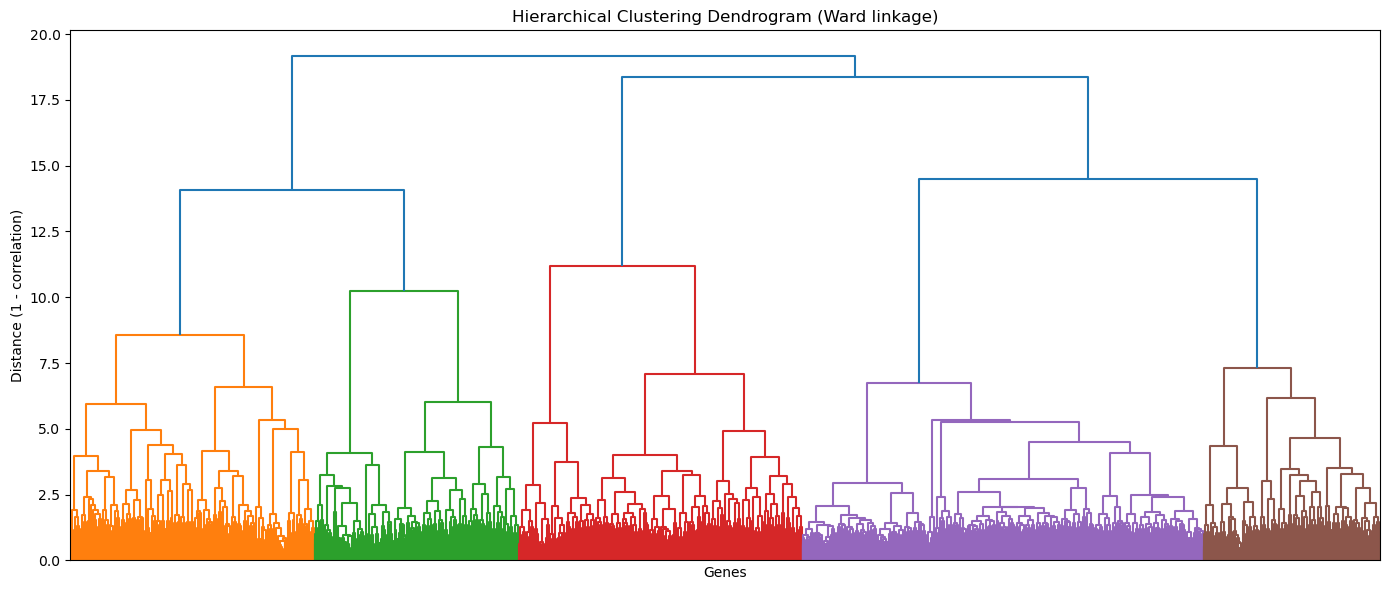

In [4]:
plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    no_labels=True,
    leaf_rotation=90,
    leaf_font_size=6,
    color_threshold=None
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Genes")
plt.ylabel("Distance (1 - correlation)")
plt.tight_layout()
plt.show()

In [5]:
k = 10   # choose based on dendrogram shape
cluster_labels = fcluster(Z, k, criterion="maxclust")

pd.Series(cluster_labels).value_counts()

8     2234
4      698
1      691
10     673
2      671
6      649
7      505
3      440
5      422
9      308
Name: count, dtype: int64

c:\Users\Kartikey Samadhiya\anaconda3\envs\bio-mllab\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Kartikey Samadhiya\anaconda3\envs\bio-mllab\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\Kartikey Samadhiya\anaconda3\envs\bio-mllab\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Kartikey Samadhiya\anaconda3\envs\bio-mllab\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


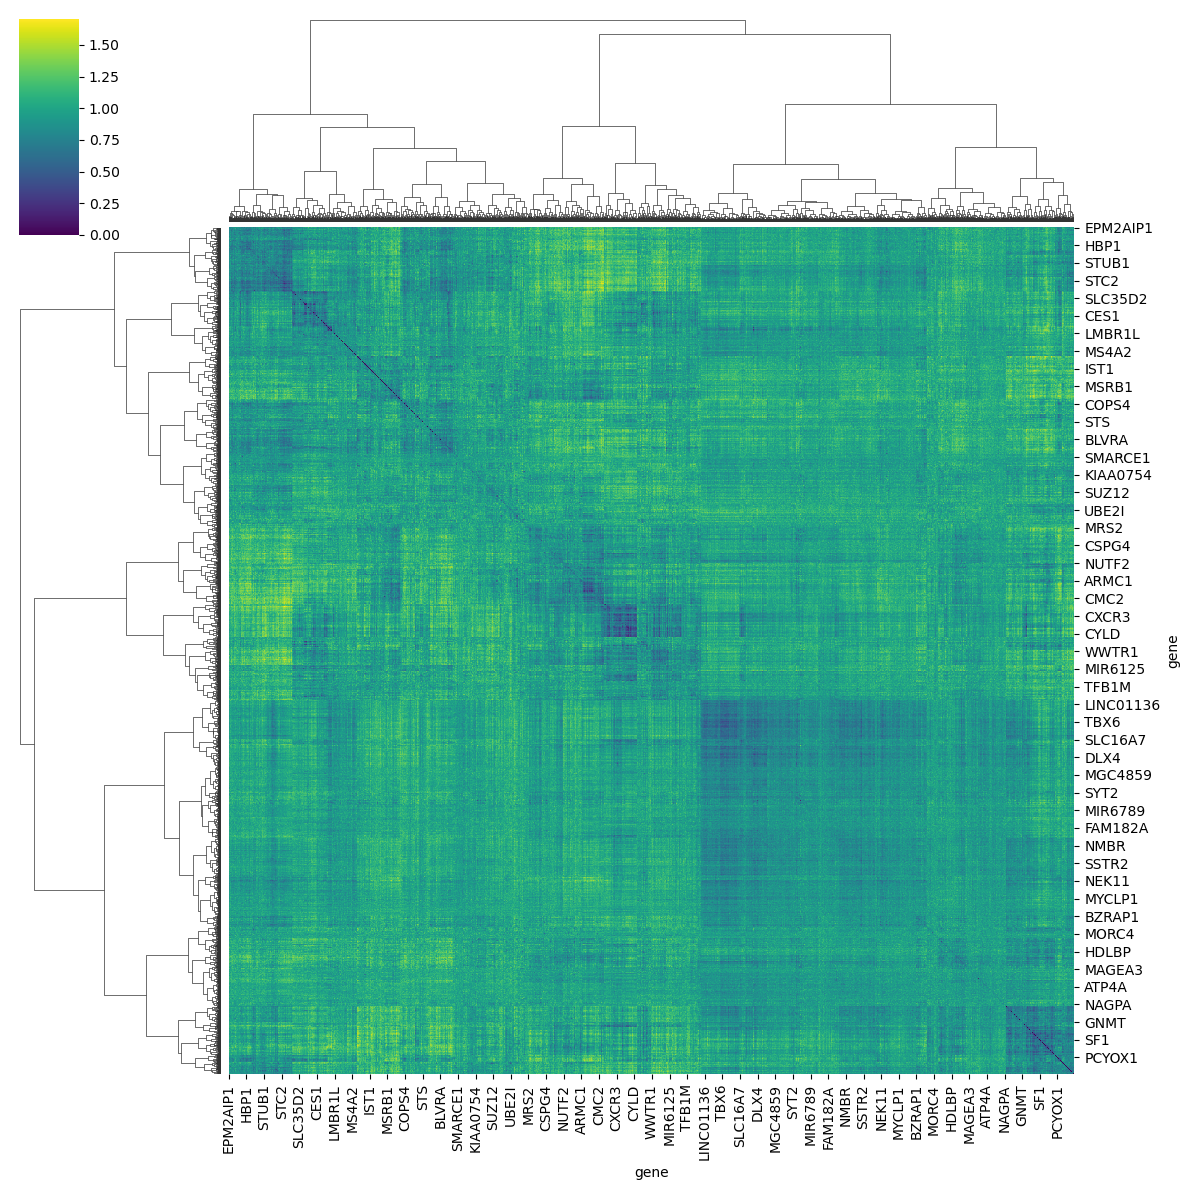

In [7]:
sns.clustermap(
    dist_matrix,
    method="ward",
    cmap="viridis",
    figsize=(12, 12)
)

In [8]:
# --- Cluster exploration across multiple cut heights ---
cluster_summaries = []

for k in [5, 8, 10, 12, 15]:
    labels = fcluster(Z, k, criterion="maxclust")
    sizes = pd.Series(labels).value_counts().sort_index()
    cluster_summaries.append(
        pd.DataFrame(
            {
                "k": k,
                "cluster_id": sizes.index,
                "size": sizes.values,
                "percentage": (sizes.values / len(labels)) * 100,
            }
        )
    )

cluster_summary_df = pd.concat(cluster_summaries, ignore_index=True)
cluster_summary_df


,k,cluster_id,size,percentage
0,5,1,1362,18.680565
1,5,2,1138,15.608284
2,5,3,1576,21.615691
3,5,4,2234,30.640516
4,5,5,981,13.454944
5,8,1,691,9.477438
6,8,2,671,9.203127
7,8,3,440,6.034837
8,8,4,698,9.573447
9,8,5,422,5.787958


In [9]:
# --- Cluster profiles at selected k ---
k_selected = 10
labels_k = fcluster(Z, k_selected, criterion="maxclust")

# Compute cluster statistics
cluster_stats = []
for cid in np.unique(labels_k):
    members = np.where(labels_k == cid)[0]
    submatrix = dist_matrix.values[np.ix_(members, members)]
    
    # Average distance within cluster (excluding diagonal)
    within_dist = submatrix[np.triu_indices(len(members), k=1)].mean()
    
    # Average distance to other clusters
    other_clusters = np.where(labels_k != cid)[0]
    if len(other_clusters) > 0:
        between_dist = dist_matrix.values[np.ix_(members, other_clusters)].mean()
    else:
        between_dist = np.nan
    
    cluster_stats.append({
        "cluster_id": cid,
        "size": len(members),
        "avg_within_distance": within_dist,
        "avg_between_distance": between_dist
    })

cluster_profiles = pd.DataFrame(cluster_stats)
cluster_profiles


,cluster_id,size,avg_within_distance,avg_between_distance
0,1,691,0.962044,1.007246
1,2,671,0.897477,1.021289
2,3,440,0.703318,1.002061
3,4,698,0.895283,1.005328
4,5,422,0.807022,0.991076
5,6,649,0.807996,1.009384
6,7,505,0.910315,1.005081
7,8,2234,0.871312,0.990813
8,9,308,0.718992,1.000576
9,10,673,0.938667,0.997155


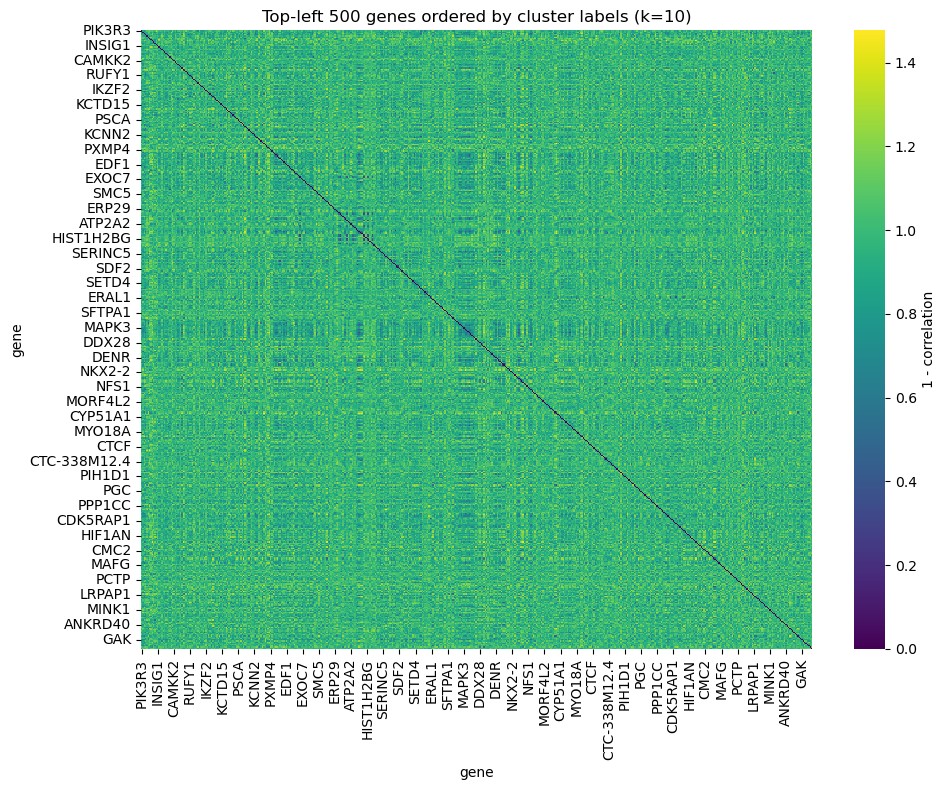

In [10]:
# --- Cluster-ordered heatmap (subset for visibility) ---
order = np.argsort(labels_k)
ordered_matrix = dist_matrix.iloc[order, order]

plt.figure(figsize=(10, 8))
sns.heatmap(
    ordered_matrix.iloc[:500, :500],
    cmap="viridis",
    cbar_kws={"label": "1 - correlation"},
)
plt.title(f"Top-left 500 genes ordered by cluster labels (k={k_selected})")
plt.tight_layout()
plt.show()


In [11]:
# --- Representative gene per cluster ---
cluster_centers = {}

for cid in np.unique(labels_k):
    members = np.where(labels_k == cid)[0]
    submatrix = dist_matrix.values[np.ix_(members, members)]
    mean_dist = submatrix.mean(axis=1)
    representative_idx = members[np.argmin(mean_dist)]
    cluster_centers[cid] = dist_matrix.index[representative_idx]

pd.Series(cluster_centers, name="representative_gene")


1        NAA60
2          TTK
3     ARHGAP25
4        SFRP1
5      ZCCHC24
6         MLPH
7         PCM1
8        ACRV1
9      ARHGDIA
10    ARHGEF11
Name: representative_gene, dtype: object